<h1 align = 'center'>Computer Vision Final Project: Breast Cancer Tumor Classification</h1>
<h2 align = 'center'>Section 1 Spring 2023</h2>
<h3 align = 'center'> Nicholas Lee, Nic Brathwaite, Amir Moayed</h3>

<h4 align = 'center'><a href = "https://github.com/NickBrath/Computer-Vision-281-Final-Project">Github Repository</a></h4>

<p align = 'center'><a href="https://colab.research.google.com/github/NickBrath/Computer-Vision-281-Final-Project/blob/main/Nick_Lee_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>


# Introduction

Breast cancer is the most prevalent form of cancer, accounting for 2,261,419 (11.7%) of the 19,292,789 cases reported worldwide in 2020 according to the world health organization. Early diagnosis of cancer is crucial in ensuring the best chances of recovery. One main method is biopsing tissue for tumor detection using immunohistochemistry staining. Staining tissues is labor and time intensive, and training an expert to interpret the results takes even longer. Even experts have bias in their analysis so a lot of research has been geared towards using machine learning and computer vision to help detect cancer faster and at scale. The purpose of this project is to create a tool to help experts classify breast tumors as either benign or malignant (cancerous) subtypes from histopathological images.

<u>Data</u>  
The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients using different magnifying factors (40X, 100X, 200X, and 400X). The dataset contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format). In total there are two major classes of identification: benign and malignant. Furthermore, there are eight sub categories of classification, 4 in each of the main categories.


<center><img src="..\..\imgs\tumor_classification_tree.png" alt="map of tumor classification" height = 400 width = 600/></center>


Possible features of benign tumors to look for in images:
histologically benign [1]
(adjective) Referring to a lesion that does not meet any criteria of malignancy – e.g., marked cellular atypia, mitosis, disruption of basement membranes, metastasize.


A study conducted to understand the patterns used by pathologists showe dthat diagnostic accuracy varied as a function of case consensus diagnosis, and bening cases often elicited false positives. While the three malignant cases often were categorized as false negative. "Pathologist experience levels, case consensus diagnosis, case difficulty, eye fixation durations, and the extent to which pathologists’ eyes fixated within versus outside of diagnostic ROIs, all independently or interactively predicted diagnostic accuracy. Higher zooming behavior predicted a tendency to over-interpret benign and atypia cases, but not DCIS cases." (Brunye et al. 2017). 

---


**Remove before submission**


Consuming TFRecord data
Refer to the Loading TFRecords tutorial for an end-to-end example.

The tf.data API supports a variety of file formats so that you can process large datasets that do not fit in memory. For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.


_look at transfer learning for other similar problems that might help our model https://www.tensorflow.org/guide/keras/transfer_learning_


---


# Setup


## Packages


In [1]:
# Google packages
# from google.colab import drive
# from google.colab import files
# from google.colab.patches import cv2_imshow

# Mount google drive
# drive.mount('/content/drive')


In [2]:
# high resolution images
%config InlineBackend.figure_format = 'retina'


In [100]:
import sys
import os
import datetime

# DS packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import date
import warnings

# image packages
# import PIL
# import urllib
# import cv2
# from skimage.color import rgb2gray
# import skimage.io as skio
# import tabulate

# ML packages

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTEN

import scipy as sc
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint

# import tensorflow_addons as tfa

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

import tomopy
import mkl

from imgaug import augmenters as iaa

# Local packages for functions
sys.path.insert(1, '../../scripts')

# data loading functions
import data_loading as dl
import dataset_creation_functions as dcf

## Image set functions
# For showing images and creating sets for plotting
import image_viewing_functions as ivf

## Augmentation functions
import augmentation_functions as af

## Model functions, like plotting history
import model_functions as mf

# Data generator for ResNet model or other models as well
import data_generator as dg

In [4]:
# options
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

# Intel(R) MKL FFT functions to run sequentially
mkl.domain_set_num_threads(1, domain='fft')

og_cmap = plt.get_cmap(name=None, lut=None)

AUTOTUNE = tf.data.AUTOTUNE
seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")

%matplotlib inline
%load_ext tensorboard


In [5]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices('GPU')


## Functions


### EDA functions


In [6]:
# Exploratory creation for std and min max of images. Uncomment to run, but should have csv already saved
# %run ../../scripts/eda_functions.py


### Model Functions


In [7]:
def launch_tensorboard(log_name):
    %tensorboard - -logdir f'./models/logs/{log_name}'


## File Paths


In [8]:
# Paths
main_path = "G:\\My Drive\\"

project_path = "w281_final_project"
project_path = os.path.join(main_path, project_path)

datadir = os.path.join(project_path, "Data")

save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("Data directory", datadir)
print("save path: ", save_path)


project path:  G:\My Drive\w281_final_project
Data directory G:\My Drive\w281_final_project\Data
save path:  G:\My Drive\w281_final_project20230421_baseline_models/


## Load tensorflow dataset to use in models


In [9]:
# load metadata information for full paths and annotations
df = dl.load_pickles(os.path.join(datadir, "pickles\metaData.pkl"))

# starting with 40x
# df = df.query('MAGNIFICATION == "40" & TUMOR_CLASS == "B"').reset_index(drop=True)

# swap beginning path from google drive to local computer path
swap_gdrive = True
if swap_gdrive: 
    pattern = "/content/drive/MyDrive/"
    replacement = "G:/My Drive/"

    df['FULL_PATH'] = df['FULL_PATH'].str.replace(pattern, replacement)

df.info()

display(df['TUMOR_TYPE'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


DC    3451
F     1014
MC     792
LC     626
TA     569
PC     560
PT     453
A      444
Name: TUMOR_TYPE, dtype: int64

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-007.png


# Fixing unbalanced classes, creating datasets and encoding labels


In [10]:
ds_og, le_og = dcf.create_one_hot_encoding(
    file_paths=df['FULL_PATH'], labels=df['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_og.classes_
lm_og = dict(zip(range(len(lc)), lc))

print(f"label map: {lm_og}")
print(f"Dataset og: {ds_og}")


label map: {0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}
Dataset og: <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>


In [11]:
x = df[['FULL_PATH']]
y = df[['TUMOR_TYPE']]

rus = RandomUnderSampler()

x_under, y_under = rus.fit_resample(x, y)
y_under.value_counts()

df_under = pd.concat([x_under, y_under], axis=1)
del x_under, y_under
df_under.TUMOR_TYPE.value_counts()

ds_under, le_under = dcf.create_one_hot_encoding(
    file_paths=df_under['FULL_PATH'], labels=df_under['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_under.classes_
lm_under = dict(zip(range(len(lc)), lc))
lm_under

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

## Oversampling


In [12]:
ros = RandomOverSampler(random_state=0)
x_over, y_over = ros.fit_resample(x, y)

df_over_rand = pd.concat([x_over, y_over], axis=1)
del x_over, y_over
df_over_rand['TUMOR_TYPE'].value_counts()


A     3451
F     3451
PT    3451
TA    3451
DC    3451
LC    3451
MC    3451
PC    3451
Name: TUMOR_TYPE, dtype: int64

In [13]:
ds_over_rand, le_over_rand = dcf.create_one_hot_encoding(
    file_paths=df_over_rand['FULL_PATH'], labels=df_over_rand['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_over_rand.classes_
lm_over_rand = dict(zip(range(len(lc)), lc))
lm_over_rand


{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

## Using SMOTE for oversampling


In [14]:
sm = SMOTEN()
x_over, y_over = sm.fit_resample(x, y)

df_over_smote = pd.concat([x_over, y_over], axis=1)
del x_over, y_over
display(df_over_smote.TUMOR_TYPE.value_counts())

ds_over_smote, le_over_smote = dcf.create_one_hot_encoding(
    file_paths=df_over_smote['FULL_PATH'], labels=df_over_smote['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_over_smote.classes_
lm_over_smote = dict(zip(range(len(lc)), lc))
lm_over_smote


A     3451
F     3451
PT    3451
TA    3451
DC    3451
LC    3451
MC    3451
PC    3451
Name: TUMOR_TYPE, dtype: int64

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

---


# Feature Engineering (35 pts)

- Label encoding
- Feature engineering

- [ ] plots showing the amount of variation in the dataset, as well as PCA decomposition and tSNE visualization of features.
- [ ] Details to why features are chosen


Features to create from main paper

- local binary patterns (17) (LBP)
- completed LBP
- local phase quantization (LPQ)
- gray-level co-occurance matric (CLCM)
- threshold adjacency statistics (TAS)


More about [batched datasets](https://www.tensorflow.org/guide/data#batching_dataset_elements)


## Train, test split for RGB


5536
1583
1581
(224, 224, 3)
(8,)


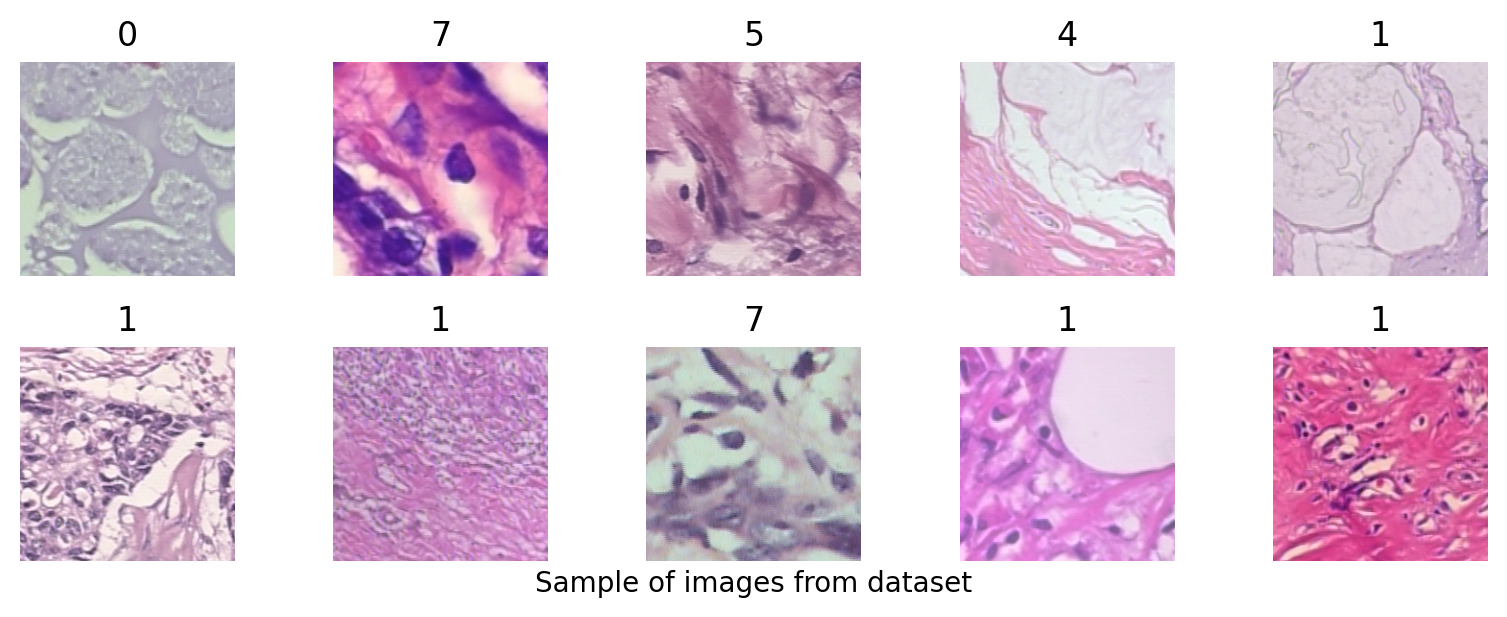

In [15]:
train_ds, val_ds, test_ds = dcf.preprocess_ds(
    ds_og, read_fn=dcf.read_image, augment_fn=dcf.augment_crop)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

train_sample = ivf.create_image_set(train_ds, num_images=10)
ivf.plot_images(train_sample, nrows=2, ncols=5)


## Adjusting Contrast


In [16]:
# train_sample = ivf.create_image_set(
#     train_ds.map(dcf.augment_contrast),
#     num_images=10)

# ivf.plot_images(train_sample,
#             nrows=2,
#             ncols=5)


In [17]:
# train_sample = ivf.create_image_set(
#     train_ds.map(dcf.augment_flip),
#     num_images=10)

# ivf.plot_images(train_sample,
#             nrows=2,
#             ncols=5)


In [18]:
# train_ds, val_ds, test_ds = dcf.preprocess_ds(ds_og, read_fn=read_image)

# train_ds = train_ds.map(augment_sobel_edges)

# train_sample = dcf.create_image_set(
#     train_ds,
#     num_images=5)

# ivf.plot_sobel_images(train_sample)


## Edges
Using the sobel-edge detection algorithms allows us to explore the differences in vertical and horizontal edges. Often tissues are represented different if they are cancerous. 

## Discussion on chosen features


---


# Classification (35 pts)


For our classifers we chose to use we create:

1. CNN Binary Classifier for Benign v. Malignant
2. ResNet Classifer for 8 classes


Create at least two classifiers:

1. SVM
2. simple perception


In [218]:
# for collecting model results
model_results_tracker = pd.DataFrame()

In [217]:
def add_model_training_results(model_name, df, model_results_tracker, result_type = 'training'): 
    
    df.insert(loc=0, column='model_name', value=model_name)
    df.insert(loc=0, column='type', value=result_type)
    df.insert(loc=0, column='date', value=datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    df.reset_index(inplace=True)
    df.rename({'index':'epoch'}, axis = 1, inplace = True)
    
    df = pd.concat([model_results_tracker, df])
    
    display(df)
    
    return df

In [21]:
METRICS = [
    'accuracy',
    keras.metrics.TruePositives(name='tp', thresholds=0),
    keras.metrics.FalsePositives(name='fp', thresholds=0),
    keras.metrics.TrueNegatives(name='tn', thresholds=0),
    keras.metrics.FalseNegatives(name='fn', thresholds=0),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]


In [22]:
# def augment_sobel_edges(image, label):
#     """ Apply the sobel-edge dector function over tensors"""

#     # add batch dimension
#     image = image[tf.newaxis, :]

#     image = tf.tile(image, (1, 1, shape[-2],shape[-1]))

#     print(tf.shape(sobel_x))

#     image = tf.image.sobel_edges(image)

#     return image, label


In [23]:
def prepare_ds(ds, shuffle=False, augment=False, batch_size=32):
    """ Prepare dataset for models. Augmentation can be appliied with the flag"""

    # create square image
    image_size = 224

    resize_rescale_layer = tf.keras.Sequential([
        tf.keras.layers.RandomCrop(
            image_size, image_size, seed=seed
        )
    ])

    data_aug_layer = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomContrast(0.2, seed=seed),
    ])

    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_rescale_layer(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_aug_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

        # ds = ds.map(lambda x, y:(histogram_equalization(x), y), num_parallel_calls = AUTOTUNE)

    # Batch all datasets.
    # ds = ds.batch(batch_size)
    ds = dcf.configure_for_performance(ds)

    return ds


## Under Sampling Method


## Base Model


We found that the base multiclassification model will work better on the subclasses if split by benign or malignant.

In [83]:
x = df[['FULL_PATH']]
y = df[['TUMOR_CLASS']]

rus = RandomUnderSampler()

x_under, y_under = rus.fit_resample(x, y)

df_under = pd.concat([x_under, y_under], axis=1)
del x_under, y_under

display(df_under.TUMOR_CLASS.value_counts())

ds_under, le_under = dcf.create_one_hot_encoding(
    file_paths=df_under['FULL_PATH'], labels=df_under['TUMOR_CLASS'])

B    2480
M    2480
Name: TUMOR_CLASS, dtype: int64

In [25]:
batch_size = 32
shape = (224, 224, 3)

# split up data
train_ds_binary, val_ds_binary, test_ds_binary = dcf.split_ds_tvt(ds_under)

test_ds_binary = test_ds_binary.map(dcf.read_image).cache().map(dcf.augment_crop).batch(32)
test_labels_binary = dcf.decoder(test_ds_binary)

# Create training objects
pathsTrain = []
labelsTrain = []

for x, y in train_ds_binary:
    pathsTrain.append(x.numpy().decode('utf-8'))
    labelsTrain.append(y.numpy())
    
pathsVal = []
labelsVal = []

for x, y in val_ds_binary:
    pathsVal.append(x.numpy().decode('utf-8'))
    labelsVal.append(y.numpy())

# Create data generators for resnet function
train_generator_binary = dg.breakHis_DataGenerator(
    pathsTrain, labelsTrain, batch_size, shape, use_cache=False, augment=False, shuffle=True)
val_generator_binary = dg.breakHis_DataGenerator(
    pathsVal, labelsVal, batch_size, shape, use_cache=False, shuffle=False)

test_binary_labels = dcf.decoder(test_ds_binary)
train_labels = dcf.decoder(train_generator_binary)

3472
992
992


In [273]:
train_labels = dcf.decoder(train_generator_binary)

In [28]:
### Binary Model
num_classes = 2
image_size = 224
model_name = 'model_binary_base_rgb'

# Create model
model_binary = tf.keras.Sequential([
    tf.keras.layers.Input((image_size, image_size, 3)),
    # same as kernel size of (3,3)
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(name = 'features_base_binary'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model_binary.summary()

# Compiling the model
model_binary.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), optimizer= mf.get_optimizer(), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(
    f"../models/checkpoints/{model_name}/", save_best_only=True,)

tensorboard_callback = mf.create_tf_board(model_name)

# Model is fitted using train and validation generator for 200 epochs
hist_base_binary= model_binary.fit(train_generator_binary,
                 validation_data=val_generator_binary,
                 epochs=2,
                 callbacks=[early_stop, checkpoint, tensorboard_callback],
                 verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 features_base_binary (Flatt  (None, 802816)           0         
 en)                                                             
                                                                 
 dense_4 (Dense)             (None, 128)               102760576 
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 102,762,626
Trainable params: 102,762,62

INFO:tensorflow:Assets written to: ../models/model_multiclass_base_rgb\assets


INFO:tensorflow:Assets written to: ../models/model_multiclass_base_rgb\assets


109/109 [==============================] - 168s 2s/step - loss: 4.1336 - accuracy: 0.6815 - val_loss: 0.7272 - val_accuracy: 0.7611
Epoch 2/2
109/109 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7324

INFO:tensorflow:Assets written to: ../models/model_multiclass_base_rgb\assets


INFO:tensorflow:Assets written to: ../models/model_multiclass_base_rgb\assets


109/109 [==============================] - 161s 1s/step - loss: 0.5879 - accuracy: 0.7324 - val_loss: 0.4445 - val_accuracy: 0.8085


,epoch,date,type,model_name,loss,accuracy,val_loss,val_accuracy
0,0,20230421-153917,training,model_binary_base__underSampling_rgb,4.133641,0.681452,0.727247,0.761089
1,1,20230421-153917,training,model_binary_base__underSampling_rgb,0.587856,0.732431,0.444467,0.808468


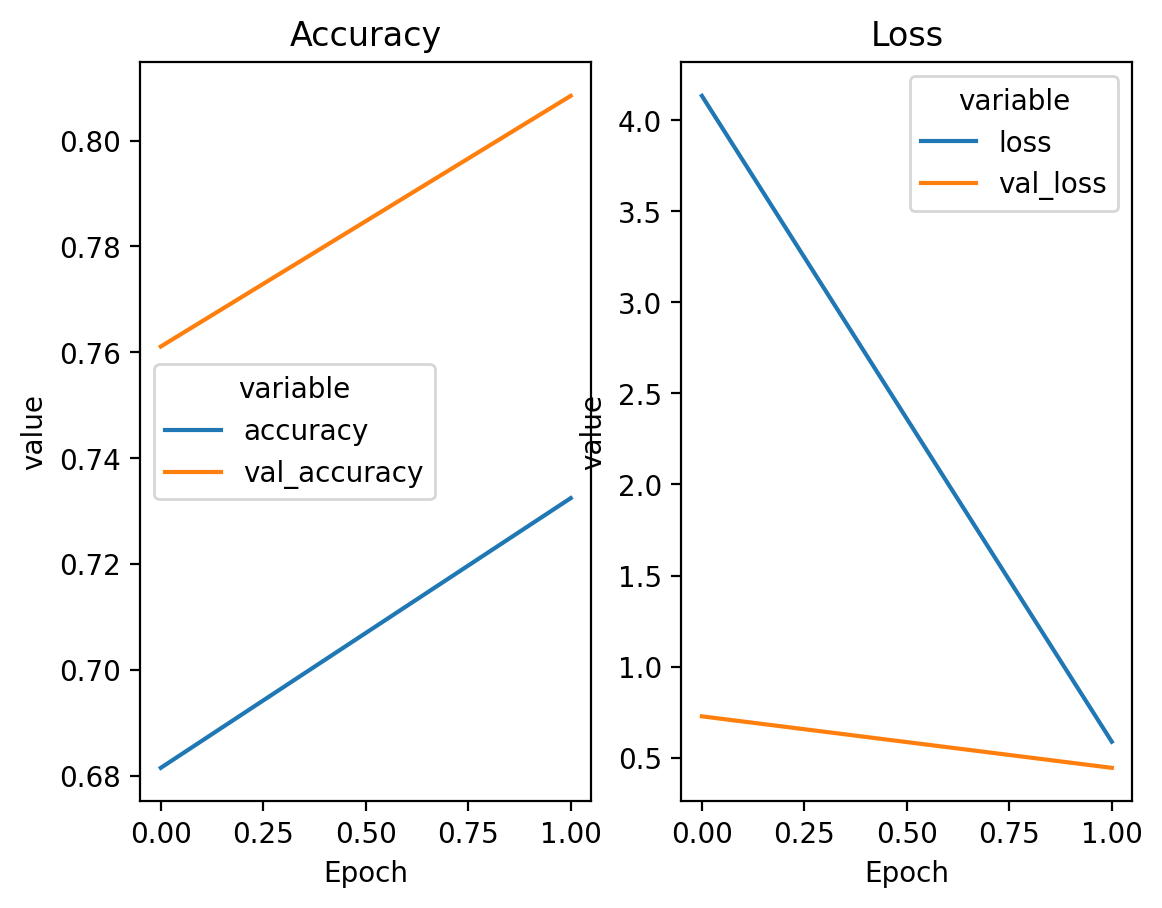

In [219]:
hist_df = pd.DataFrame(hist_base_binary.history)

model_results_tracker = add_model_training_results('model_binary_base__underSampling_rgb', hist_df, model_results_tracker)

# plot model training results
mf.plot_hist(hist_base_binary)

In [227]:
model_path = f'../../models/{model_name}_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
model_amir_binary.save(model_path)

In [108]:
train_predictions_binary = model_binary.predict(train_generator_binary).argmax(axis=1)
test_predictions_binary = model_binary.predict(test_ds_binary).argmax(axis=1)

test_predictions_binary = le_under.inverse_transform(test_predictions_binary)
test_labels_binary = le_under.inverse_transform(test_labels_binary)

print(classification_report(test_labels_binary, test_predictions_binary))

mf.multi_label_cm(test_labels_binary, test_predictions_binary)

31/31 [==============================] - 17s 557ms/step


In [ ]:
model_binary.save(f'../../models/{model_name}.h5')

### Amir's Model for binary classification

### feeding binary classification into cnn for tumor type classification

In [176]:
# multiclassifcation model(s)
num_classes = 2
image_size = 224
epochs = 2
model_name = 'model_amir_binary'

def create_cancer_model(): 
    """ """  
    model = tf.keras.Sequential([        
        # CNN
        tf.keras.layers.Input((224,224,3)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Flatten(name='feature_extractor'),
        Dense(256, activation = 'relu'),
        Dense(125, activation = 'relu'),
        Dense(2, activation = 'softmax')
        ])
    
    return model

model_amir_binary = create_cancer_model()

# Compiling the model
model_amir_binary.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), optimizer=mf.get_optimizer(), metrics=['accuracy'])

# Call Backs
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(
    f"../models/checkpoints/{model_name}/", save_best_only=True,)

tensorboard_callback = mf.create_tf_board(model_name)

# Model is fitted using train and validation generator for 200 epochs
hist_amir_binary = model_amir_binary.fit(train_generator_binary,
                 validation_data=val_generator_binary,
                 epochs=epochs,
                 callbacks=[early_stop, checkpoint, tensorboard_callback],
                 verbose=1)

Epoch 1/2
109/109 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.6688

INFO:tensorflow:Assets written to: ../models/model_amir_binary\assets


INFO:tensorflow:Assets written to: ../models/model_amir_binary\assets


109/109 [==============================] - 102s 931ms/step - loss: 0.6025 - accuracy: 0.6688 - val_loss: 0.5365 - val_accuracy: 0.7651
Epoch 2/2
109/109 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7563

INFO:tensorflow:Assets written to: ../models/model_amir_binary\assets


INFO:tensorflow:Assets written to: ../models/model_amir_binary\assets


109/109 [==============================] - 100s 916ms/step - loss: 0.5265 - accuracy: 0.7563 - val_loss: 0.5018 - val_accuracy: 0.7823


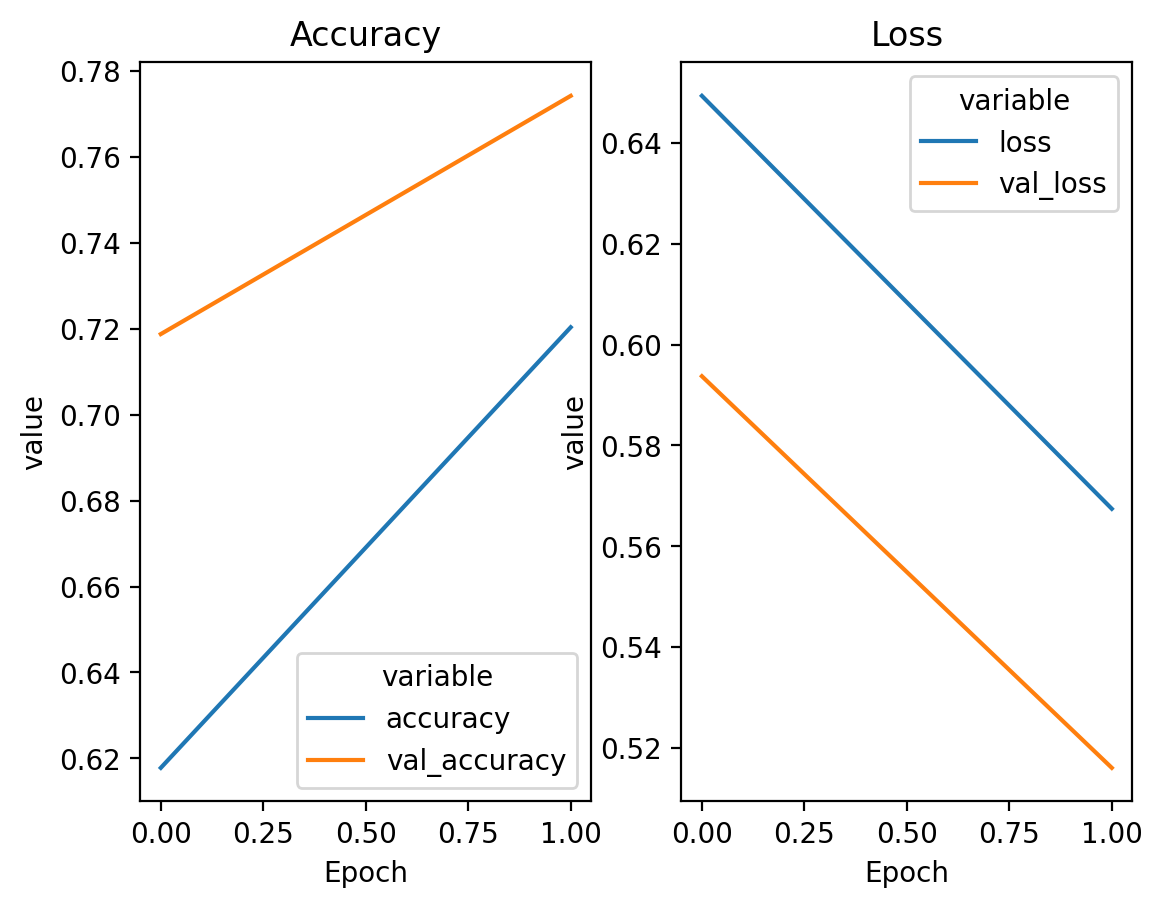

In [167]:
# plot model training results
mf.plot_hist(hist_amir_binary)

In [220]:
amir_hist_df = pd.DataFrame(hist_amir_binary.history)
model_results_tracker = add_model_training_results(model_name,amir_hist_df , model_results_tracker)
model_results_tracker

,epoch,date,type,model_name,loss,accuracy,val_loss,val_accuracy
0,0,20230421-153917,training,model_binary_base__underSampling_rgb,4.133641,0.681452,0.727247,0.761089
1,1,20230421-153917,training,model_binary_base__underSampling_rgb,0.587856,0.732431,0.444467,0.808468
0,0,20230421-153925,training,model_amir_binary,0.602510,0.668779,0.536487,0.765121
1,1,20230421-153925,training,model_amir_binary,0.526475,0.756336,0.501832,0.782258


,epoch,date,type,model_name,loss,accuracy,val_loss,val_accuracy
0,0,20230421-153917,training,model_binary_base__underSampling_rgb,4.133641,0.681452,0.727247,0.761089
1,1,20230421-153917,training,model_binary_base__underSampling_rgb,0.587856,0.732431,0.444467,0.808468
0,0,20230421-153925,training,model_amir_binary,0.602510,0.668779,0.536487,0.765121
1,1,20230421-153925,training,model_amir_binary,0.526475,0.756336,0.501832,0.782258


31/31 [==============================] - 16s 499ms/step
              precision    recall  f1-score   support

           B       0.48      0.52      0.50       485
           M       0.50      0.47      0.48       507

    accuracy                           0.49       992
   macro avg       0.49      0.49      0.49       992
weighted avg       0.49      0.49      0.49       992

True Negatives:  251
False Positives:  234
False Negatives:  271
True Positives:  236
Total Malignant Cases:  507


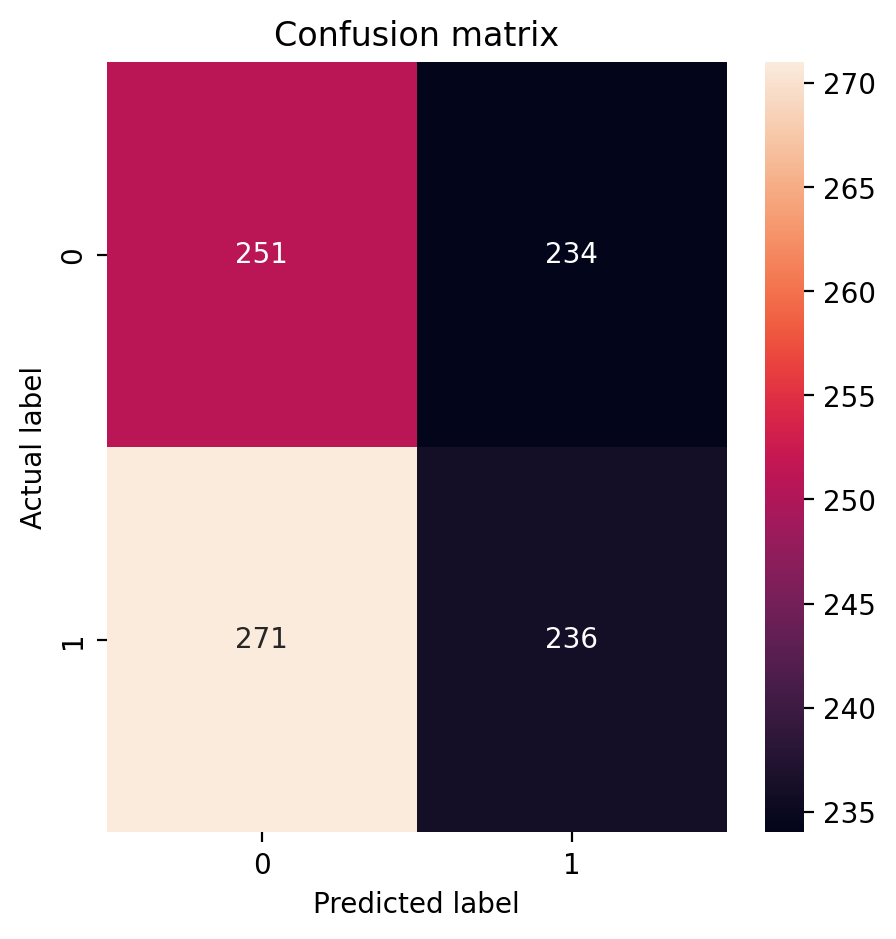

In [221]:
train_predictions_amir_binary = model_amir_binary.predict(train_generator_binary).argmax(axis=1)
test_predictions_amir_binary = model_amir_binary.predict(test_ds_binary).argmax(axis=1)

test_predictions_amir_binary = le_under.inverse_transform(test_predictions_amir_binary)

print(classification_report(test_labels_binary, test_predictions_amir_binary))

mf.multi_label_cm(test_labels_binary, test_predictions_amir_binary)


In [248]:
model_path = f'../../models/{model_name}_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
model_amir_binary.save(model_path)

In [226]:
# load model
# new_model = tf.keras.models.load_model(model_path)

#### Random Forest
strategy is to take feature_extractor, last flatten layer, and pass into RF. 

using sklearn.ensemble.RandomForestClassifier. Takes the categories and not one hot encoded varaiables

In [249]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 26, 26, 32)     

In [266]:
feature_extractor = Sequential()
feature_extractor.add(tf.keras.layers.Input((224,224,3)))
for layer in new_model.layers[:-3]: # go through until last layer
    feature_extractor.add(layer)

feature_extractor.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 26, 26, 32)     

In [268]:
# Features
X_rf = feature_extractor.predict(train_generator_binary)

109/109 [==============================] - 62s 571ms/step


In [269]:
# setup model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 50, random_state=26)

In [278]:
train_labels

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [279]:
X_rf

array([[0.        , 0.01187249, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06292091, 0.16972515, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01664111, 0.10459533, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [281]:
def get_tensor_image_labels(ds): 
    """ Extract image arrays and labels from tensor dataset """
    
    imgs = np.concatenate([x for x, y in ds], axis=0)
    labels = np.concatenate([y for x, y in ds], axis=0)
    return imgs, labels


In [285]:
test_ds_rf_features, test_ds_rf_labels = get_tensor_image_labels(test_ds_binary)

In [292]:
test_ds_rf_labels = le_under.inverse_transform(test_ds_rf_labels.argmax(axis=-1))

In [ ]:
# Train modle
rf_hist = rf_model.fit(X_rf, train_labels)

In [287]:
# predictions
X_test_rf = feature_extractor.predict(test_ds_rf_features)

prediction_rf = rf_model.predict(X_test_rf)
prediction_rf_labels = le_under.inverse_transform(prediction_rf)

31/31 [==============================] - 2s 54ms/step


              precision    recall  f1-score   support

           B       0.52      0.57      0.54       491
           M       0.53      0.47      0.50       501

    accuracy                           0.52       992
   macro avg       0.52      0.52      0.52       992
weighted avg       0.52      0.52      0.52       992

True Negatives:  282
False Positives:  209
False Negatives:  264
True Positives:  237
Total Malignant Cases:  501


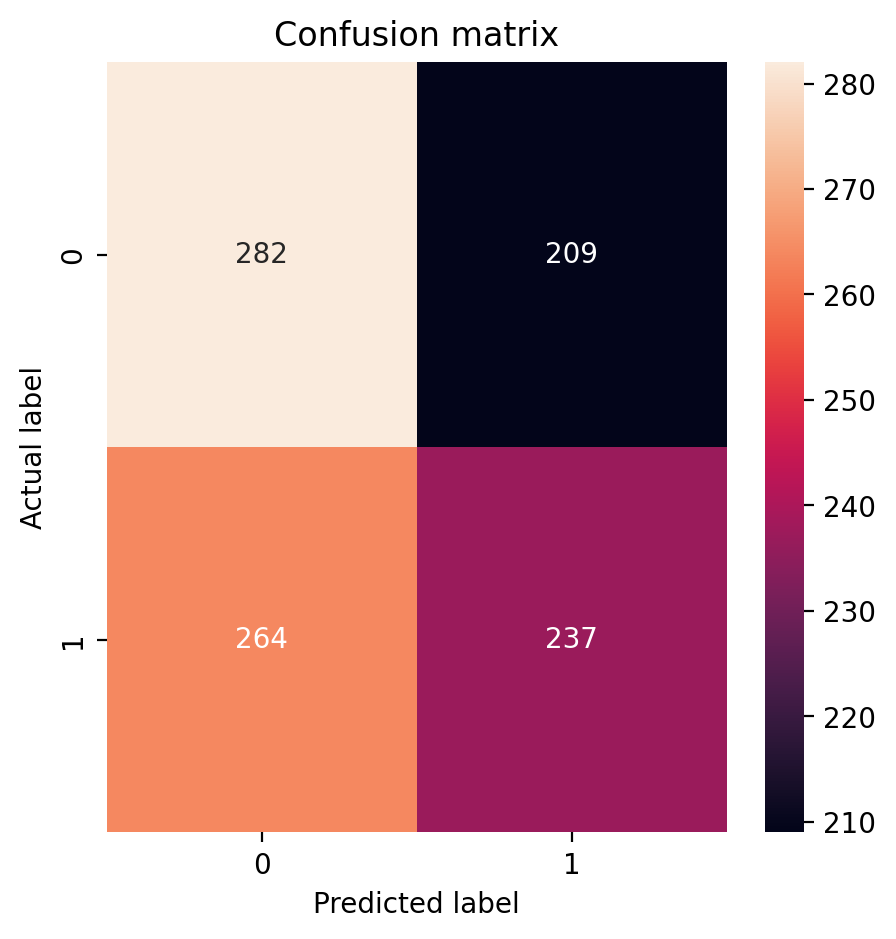

In [295]:
# train_predictions = model.predict(train_ds).argmax(axis=1)
# test_predictions = prediction_rf_labels.argmax(axis=1)

print(classification_report(test_ds_rf_labels, prediction_rf_labels))

mf.multi_label_cm(test_ds_rf_labels, prediction_rf_labels)

### Res Net Classifier Binary


In [296]:
# hard coded variables
batch_size = 32
num_classes = 2
shape = (224, 224, 3)
model_name = 'rs50_binary_rgb'

In [297]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(
    lr=learning_rate, momentum=0.5, nesterov=True)

In [304]:
# initiate resnet50 model1
rs50_base = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# set trainability for layers
for layer in rs50_base.layers[0:-10]:
    layer.trainable = False
for layer in rs50_base.layers[-10:-1]:
    layer.trainable = True

# Add last layers to fit shape of data and number of classes
rs50 = tf.keras.layers.GlobalAveragePooling2D()(rs50_base.output)
rs50 = tf.keras.layers.Dense(1024, activation='relu')(rs50)
rs50_features = tf.keras.layers.Flatten()(rs50)
rs50 = tf.keras.layers.Dense(num_classes, activation='softmax')(rs50_features)

rs50 = tf.keras.Model(inputs=rs50_base.inputs, outputs=rs50)

rs50.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), optimizer=optimizer, metrics=['accuracy'])


# Setup call backs
early_stop = EarlyStopping(monitor='loss', patience=5)
checkpoint = ModelCheckpoint(
    f"../models/checkpoints/{model_name}/", save_best_only=True,)

tensorboard_callback = mf.create_tf_board(model_name)

# Train Model
rs50_binary_hist = rs50.fit(
    train_generator_binary, 
    steps_per_epoch=len(train_generator_binary),
    validation_data=val_generator_binary,
    validation_steps=64,
    verbose=1,
    epochs=200,
    callbacks=[early_stop, checkpoint, tensorboard_callback])

hist_df = pd.DataFrame(rs50_binary_hist.history)

model_results_tracker = add_model_training_results(model_name, hist_df, model_results_tracker)

# plot model training results
mf.plot_hist(hist_base_binary)

model_path = f'../../models/{model_name}_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
rs50.save(model_path)

Epoch 1/200


Exception ignored in: <function UniquePtr.__del__ at 0x000002C9B24177F0>
Traceback (most recent call last):
  File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


 23/109 [=====>........................] - ETA: 1:42 - loss: 0.7009 - accuracy: 0.5163

KeyboardInterrupt: 

In [ ]:
train_predictions_rs50_binary = rs50.predict(train_generator_binary).argmax(axis=1)
test_predictions_rs50_binary = rs50.predict(test_ds_binary).argmax(axis=1)

test_predictions_rs50_binary = le_under.inverse_transform(test_predictions_rs50_binary)

print(classification_report(test_labels_binary, test_predictions_rs50_binary))

mf.multi_label_cm(test_labels_binary, test_predictions_rs50_binary)


# Multiclass classification

Engineering soble-edges, because texture appears to play a large role in classifcaitons

## CNN Model

In [ ]:
# multiclassifcation model(s)
num_classes = 8
image_size = 224
epochs = 25
model_name = 'model_amir_multiclass'

model_amir_multiclass = tf.keras.Sequential([        
    # CNN
    tf.keras.layers.Input((224,224,3)),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.4),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.4),
    Flatten(name='feature_extractor'),
    Dense(256, activation = 'relu'),
    Dense(125, activation = 'relu'),
    Dense(2, activation = 'softmax')
    ])

# Compiling the model
model_amir_multiclass.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), optimizer=mf.get_optimizer(), metrics=['accuracy'])

# Call Backs
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(
    f"../models/checkpoints/{model_name}/", save_best_only=True,)

tensorboard_callback = mf.create_tf_board(model_name)

# Model is fitted using train and validation generator for 200 epochs
model_amir_multiclass_hist = model_amir_multiclass.fit(train_generator_binary,
                 validation_data=val_generator_binary,
                 epochs=epochs,
                 callbacks=[early_stop, checkpoint, tensorboard_callback],
                 verbose=1)

# Save History
amir_hist_df = pd.DataFrame(model_amir_multiclass.history)
model_results_tracker = add_model_training_results(model_name, amir_hist_df, model_results_tracker)

# Save the Model
model_path = f'../../models/{model_name}_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
model_amir_multiclass.save(model_path)

# plot model training results
mf.plot_hist(hist_amir_binary)

# Create predictions and view confusion matrix
train_predictions_amir_binary = model_amir_multiclass.predict(train_generator_binary).argmax(axis=1)
test_predictions_amir_binary = model_amir_multiclass.predict(test_ds_binary).argmax(axis=1)
test_predictions_amir_binary = le_under.inverse_transform(test_predictions_amir_binary)

print(classification_report(test_labels_binary, test_predictions_amir_binary))
mf.multi_label_cm(test_labels_binary, test_predictions_amir_binary)

### Res Net Classifier Multiclassification


In [ ]:
# hard coded variables
batch_size = 32
num_classes = 8
shape = (224, 224, 3)

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(
    lr=learning_rate, momentum=0.5, nesterov=True)

In [ ]:
# split up data
train_ds, val_ds, test_ds = dcf.split_ds_tvt(ds_og)

test_ds = test_ds.map(dcf.read_image).map(dcf.augment_crop)
test_ds

# Create training objects
pathsTrain = []
labelsTrain = []

for x, y in train_ds:
    pathsTrain.append(x.numpy().decode('utf-8'))
    labelsTrain.append(y.numpy())
    
pathsVal = []
labelsVal = []

for x, y in val_ds:
    pathsVal.append(x.numpy().decode('utf-8'))
    labelsVal.append(y.numpy())

# Create data generators for resnet function
train_generator = dg.breakHis_DataGenerator(
    pathsTrain, labelsTrain, batch_size, shape, use_cache=False, augment=False, shuffle=True)
val_generator = dg.breakHis_DataGenerator(
    pathsVal, labelsVal, batch_size, shape, use_cache=False, shuffle=False)


In [ ]:
# initiate resnet50 model1
rs50_base = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# set trainability for layers
for layer in rs50_base.layers[0:-10]:
    layer.trainable = False
for layer in rs50_base.layers[-10:-1]:
    layer.trainable = True

# Add last layers to fit shape of data and number of classes
rs50 = tf.keras.layers.GlobalAveragePooling2D()(rs50_base.output)
rs50 = tf.keras.layers.Dense(1024, activation='relu')(rs50)
rs50_features = tf.keras.layers.Flatten()(rs50)
rs50 = tf.keras.layers.Dense(num_classes, activation = 'softmax')(rs50_features)

rs50 = tf.keras.Model(inputs=rs50_base.inputs, outputs=rs50)

rs50.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), optimizer=optimizer, metrics=['accuracy'])


# Setup call backs
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint("../models/resnet_model/", save_best_only=True,)
tensorboard_callback = dcf.create_tf_board("resnet_model")

# Train Model
rs50.fit(train_generator, steps_per_epoch=len(train_generator), validation_data=val_generator,
         validation_steps=64, verbose=1, epochs=200, callbacks=[early_stop, checkpoint, tensorboard_callback])

# save results
rs50.save("../models/rs50.h5")



### Evaluate Model


In [ ]:
score = rs50.evaluate(test_ds)

In [ ]:
# model.predict(test_ds)

In [ ]:
train_predictions = model.predict(train_ds).argmax(axis=1)
test_predictions = model.predict(test_ds).argmax(axis=1)

print(classification_report(test_labels, test_predictions))

ivf.multi_label_cm(test_labels, test_predictions)

### Train with Sobel Edges

---


## Model Performance

$\text{Patient Score} = \frac{N_{rec}}{N_p}$

## Global Patient Recognition Rate

$\text{Patient Recognition Rate} = \frac{\Sigma Patient Score}{Total Number of Patients}$

$\text{Image Recognition Rate} = \frac{N_{rec}}{N_{all}}$


## Export Model


In [ ]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
tf.keras.experimental.export_saved_model(model, export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))


In [ ]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path,
                                                       custom_objects={'KerasLayer': hub.KerasLayer})


# Generalizability (10 pts)


# Discussion (5 pts)


Results for other cancer detection alogirhtms include Genie Classifier algorithm (Rizzardi et al., “Quantitative Comparison of Immunohistochemical Staining Measured by Digital Image Analysis versus Pathologist Visual Scoring.”).  

Color Deconvolution algorithm showed promise too in this paper (Rizzardi et al., “Quantitative Comparison of Immunohistochemical Staining Measured by Digital Image Analysis versus Pathologist Visual Scoring.”). These algorithms could be used in future work to improve the results of our models.

Image segmentation appears to be a large factor in determining the types of cancer present in biopsy slides. This is because it is important for pathologist need to identify the key  tissues invovled in the type of carcinoma they are looking for. In breast tissue for example, if they suspect ductal carcinomia the ROI would be the ductal structures. This can be different to represent in 2D images, but the morphology could be used as features in a machine learning model. Additional work is being done related to this topic in these papers. 

Additionally companies like Nanostring have developed multi-color panels to detect the presents of different antigens. These multi-plexing methods offer pathologists a way to understand the co-localization of tumor makers in samples. This could be key to understanding the inner complexities of drug resistant cancers. An example of this can be seen from figure 1 of this paper (Cancers (Basel). 2020 Dec; 12(12): 3551.)

<center><img src="../../imgs/nanostring_multiplex.png" alt="map of tumor classification" height = 400 width = 500/></center>


# References


1. Spanhol, F., Oliveira, L. S., Petitjean, C., Heutte, L., A Dataset for Breast Cancer Histopathological Image Classification, IEEE Transactions on Biomedical Engineering (TBME), 63(7):1455-1462, 2016. [pdf]
2. Spanhol, F., Oliveira, L. S., Petitjean, C., and Heutte, L., Breast Cancer Histopathological Image Classification using Convolutional Neural Network, International Joint Conference on Neural Networks (IJCNN 2016), Vancouver, Canada, 2016.
3. Data: https://www.kaggle.com/datasets/ambarish/breakhis/code
4. Dataset background and collection information: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/
5. Brunyé, Tad T., Ezgi Mercan, Donald L. Weaver, and Joann G. Elmore. “Accuracy Is in the Eyes of the Pathologist: The Visual Interpretive Process and Diagnostic Accuracy with Digital Whole Slide Images.” Journal of Biomedical Informatics 66 (February 1, 2017): 171–79. https://doi.org/10.1016/j.jbi.2017.01.004.
